In [ ]:
####################################################
# Multi-class classification                       #
# - with cross-validation                          #
# - and bootstrap aggregation                      #
# in python, using sklearn                         #
#                                                  #
# Author: Lee Jollans (lee_jollans@psych.mpg.de)   #
####################################################

there are 3 groups


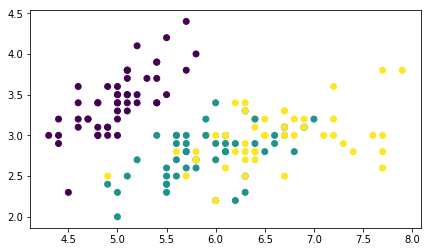

In [210]:
# module imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

# import some data to play with. this is a commonly used dataset for demonstrating clustering techniques
# the data are three different types of flowers and features are things like petal length
iris = datasets.load_iris()
X = iris.data[:,:2]  # we only take the first two features.
Y = iris.target

# shuffle the data because they're sorted by group so the first 50 are group 1, then group 2, then group 3.
# this messed up the cross-validation fold assignment as the folds were majority one group only
ss=np.linspace(0,len(Y)-1,len(Y))
np.random.shuffle(ss)
X=X[ss.astype(int),:]
Y=Y[ss.astype(int)]

# have a look at the data
nclus=len(set(Y))
print('there are ' + str(nclus) + ' groups')

# plot the data to have a look at its structure (always a good idea!)
fig=plt.figure(figsize=[7,4])
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()


In [211]:
# function for carrying out the regression

from sklearn.linear_model import LogisticRegression

def log_in_CV(x2use,y2use):
    # we'll be making a classifier for each group separately
    allbetas=np.zeros(shape=[x2use.shape[1],len(set(y2use))]) # pre-allocate the array because we'll be filling it step by step
    u=set(y2use) # the unique values for y, i.e. the groups we have
    ctr=-1 # we're starting a counter because the groups might be [2,3,4] but we want to populate the array as [0,1,2]
    for n in u: # loop over the groups
        ctr+=1
        y=np.zeros(shape=[y2use.shape[0]])
        y[np.where(y2use==n)]=1
        # now there are just 2 groups: those in my target group and those outside my target group
        clf = LogisticRegression(random_state=0, solver='lbfgs')
#        try:
        res=clf.fit(x2use,y)
        allbetas[:,ctr]=clf.coef_
#        except:
#            print(Yboot.shape)
#            print(np.sum(Yboot))

    return allbetas

In [212]:
# subsampling example
# before defining the function that selects random subsets of our data for bootstrap aggregation let's look at how it works
from random import randrange

dataset=X # our original, whole sample we want to select a subset from
ratio=0.66 # the portion of observation from X that we want in out subset
totalN=dataset.shape[0]
sample = list() # this is pre-allocated to be populated in a loop
n_sample = round(len(dataset) * ratio) # how many unique observations do we need to pick?
print('our sample has N=' + str(totalN) + '. With the ratio ' + str(ratio) + ' we want ' + str(n_sample) + ' of them')

# now fetch datapoints from X 
while len(set(sample)) < n_sample: # until we have as many unique values picked as we want
    index = randrange(totalN) # this picks a random number between 0 and totalN
    sample.append(index) # add it to our subset sample list
print('after picking ' + str(len(sample)) + ' indices, ' + str(len(set(sample))) + ' unique indices have been picked')

# we want to choose with replacement so the new sample is just as large as the original sample
if len(sample) < totalN:
    print('we have picked less indices than the original sample size so need to draw some more from our already selected set')
    while len(sample) < totalN:
        index = randrange(len(sample))
        sample.append(sample[index])
else:
    print('enough indices have been picked')

print('a total of ' + str(len(sample)) + ' indices have been picked, including ' + str(len(set(sample))) + ' unique indices.')    

# try running this box again - how many indices you pick before you have enough unique ones varies

our sample has N=150. With the ratio 0.66 we want 99 of them
after picking 170 indices, 99 unique indices have been picked
enough indices have been picked
a total of 170 indices have been picked, including 99 unique indices.


In [213]:
# define function to take subsets of the sample for bootstrap aggregation
from random import randrange
def subsample(dataset, ratio=1.0):
    totalN=dataset.shape[0]
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(set(sample)) < n_sample:
        index = randrange(len(dataset))
        sample.append(index)
    while len(sample) < totalN:
        index = randrange(len(sample))
        sample.append(sample[index])
    return sample

In [214]:
# bootstrap aggregation
# add bootstrapping to the function that carries out the regression
def bag_log(x2use,y2use,nboot):
    allbetas=np.zeros(shape=[x2use.shape[1],len(set(y2use)),nboot]) # pre-allocate
    for i in range(nboot):
        # get and select the bootstrap sample
        bootidc = subsample(x2use, 0.666) 
        Xboot = x2use[bootidc,:]
        Yboot = y2use[bootidc]
        # run it through the regression and save regression weights
        allbetas[:,:,i]=log_in_CV(Xboot,Yboot)
    # average regression weight from all bootstrap runs
    betas=np.nanmean(allbetas,axis=2)
    return betas # and spit them out again at the end

there are 50 observations belonging to 3 groups
    AUC: 1.0, F1 score: 1.0
    AUC: 0.7857142857142857, F1 score: 0.6666666666666666
    AUC: 0.8238095238095239, F1 score: 0.7586206896551724
there are 50 observations belonging to 3 groups
    AUC: 1.0, F1 score: 1.0
    AUC: 0.69376026272578, F1 score: 0.6909090909090908
    AUC: 0.7736185383244207, F1 score: 0.6956521739130435
there are 50 observations belonging to 3 groups
    AUC: 1.0, F1 score: 1.0
    AUC: 0.8392857142857143, F1 score: 0.8301886792452831
    AUC: 0.8214285714285714, F1 score: 0.5161290322580645


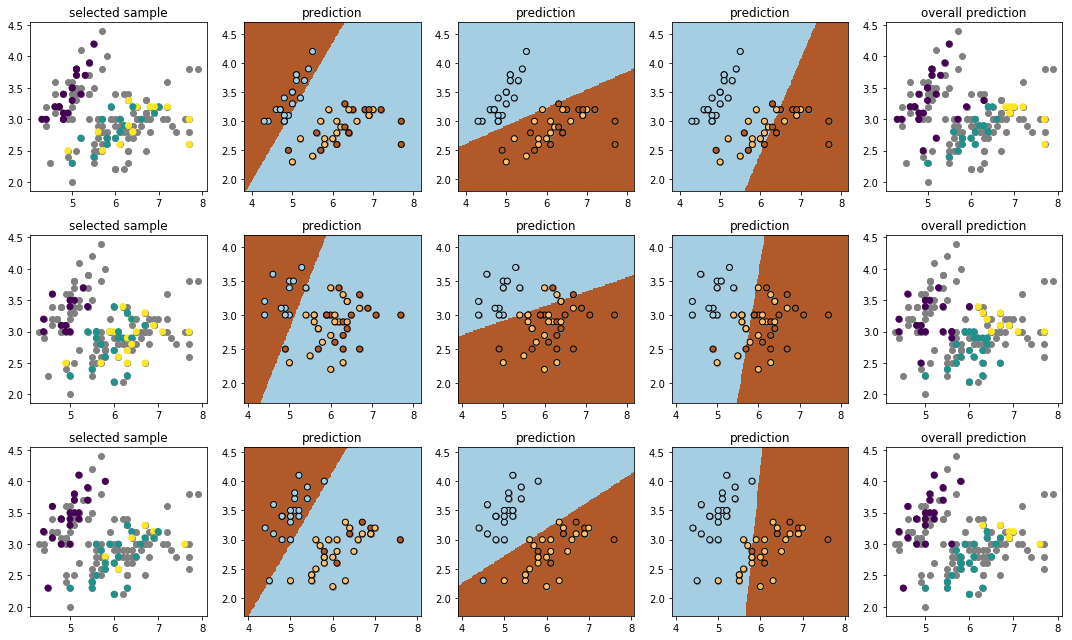

In [266]:
# example
# now let's go through the whole process and see what we get!

samplesize=50 # we'll not do the try on the whole dataset because we're only testing
ntries=3 # try the process a few times - each should give slightly different results!

fig=plt.figure(figsize=[15,3*ntries])

ctr=0
for tries in range(ntries):

    # select the sample
    sample2use=np.linspace(0,X.shape[0]-1,X.shape[0])
    np.random.shuffle(sample2use)
    sample2use=sample2use[:samplesize]
    #print('These are the cases we are going to look at for the example:' + str(sample2use))
    x2use=X[sample2use.astype(int),:]
    y2use=Y[sample2use.astype(int)]
    print('there are ' + str(len(y2use)) + ' observations belonging to ' + str(len(set(y2use))) + ' groups')
    pred=np.zeros(shape=[samplesize,len(set(y2use))])
    
    # plot selected sample
    ctr+=1
    ax=fig.add_subplot(ntries,5,ctr)
    ax.scatter(X[:,0],X[:,1],c="grey")
    ax.scatter(x2use[:,0],x2use[:,1],c=y2use)
    plt.title('selected sample')
    
    # get betas (without bootstrap aggregation for the example)
    allbetas=log_in_CV(x2use,y2use)
    
    ## plot betas
    #ctr+=1
    #fig.add_subplot(ntries,9,ctr)
    #plt.plot(allbetas); plt.title('betas for all groups'); plt.xlabel('features'); 
    
    # now get the model fir (how good is the prediction?) for each group
    for n in range(len(set(y2use))):
        # same data prediction
        pred[:,n]=np.squeeze(x2use.dot(allbetas[:,n])) # calculate the predicted values (X*beta)
        truth=np.zeros(shape=[samplesize]); truth[np.where(y2use==n)[0]]=1 # construct the true value (again 0,1 for one group versus all others)
        fpr,tpr,thresholds=roc_curve(truth,pred[:,n]) # calculate the ROC curve
        point=np.argmax(tpr-fpr) # figure out the point we want to use as the threshold in the ROC curve, this minimizes false-positive rate and maximizes true-positive rate
        
        ## plot the ROC curve
        #ctr+=1
        #ax=fig.add_subplot(ntries,9,ctr)
        #ax.plot(fpr,tpr); plt.xlabel('false positive rate'); plt.ylabel('true positive rate')
        #ax.plot(fpr[point],tpr[point],"or")
        #plt.title(('group ' + str(n)))

        # get the AUC and F1 score: metrics of how good the prediction is
        newpred=np.zeros(shape=[samplesize])
        newpred[np.where(pred[:,n]>=thresholds[point])]=1           
        aucs=roc_auc_score(truth,newpred)
        f1s=f1_score(truth,newpred)
        print('    AUC: '+ str(aucs) + ', F1 score: '+ str(f1s))

        # plot the prediction with decision boundary
        ctr+=1
        ax=fig.add_subplot(ntries,5,ctr)
        x_min, x_max = x2use[:, 0].min() - .5, x2use[:, 0].max() + .5
        y_min, y_max = x2use[:, 1].min() - .5, x2use[:, 1].max() + .5
        h = .02  # step size in the mesh
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z=np.squeeze(np.c_[xx.ravel(), yy.ravel()].dot(allbetas[:,n]))
        newZ=np.zeros(shape=[Z.shape[0]])
        newZ[np.where(Z>=thresholds[point])]=1 
        Z = newZ.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
        ax.scatter(x2use[:,0],x2use[:,1],c="grey")
        ax.scatter(x2use[:, 0], x2use[:, 1], c=y2use, edgecolors='k', cmap=plt.cm.Paired)
        plt.title(('prediction'))
        
        pred[:,n] = (pred[:,n]-min(pred[:,n]))/(max(pred[:,n])-min(pred[:,n]))
        
    # figure out overall which group they would be put in
    groupclass=np.zeros(shape=[samplesize])
    for n in range(len(set(y2use))):
        groupclass[np.where(np.max(pred-np.expand_dims(pred[:,n],axis=1),axis=1)==0)]=n
    # plot overall prediction
    ctr+=1
    ax=fig.add_subplot(ntries,5,ctr)
    ax.scatter(X[:,0],X[:,1],c="grey")
    ax.scatter(x2use[:,0],x2use[:,1],c=groupclass)
    plt.title('overall prediction')
        

plt.tight_layout()
plt.show()


In [267]:
# make a function to get the AUC and F1 values
# get the  AUC and F1 values to check how good the model actually is
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
import matplotlib.pyplot as plt

def getmetrics(x2use, truth,betas2use):

    pred=np.squeeze(x2use.dot(betas2use))

    fpr,tpr,thresholds=roc_curve(truth,pred)
    point=np.argmax(tpr-fpr)

    newpred=np.zeros(shape=[pred.shape[0]])
    newpred[np.where(pred>=thresholds[point])]=1
        
    aucs=roc_auc_score(truth,newpred)
    f1s=f1_score(truth,newpred)
    
    return aucs, f1s, newpred

In [268]:
# define cross-validation
nfolds=3
from sklearn.model_selection import KFold
kf = KFold(n_splits=nfolds)
print('we are doing ' + str(nfolds) + '-fold cross-validation')

we are doing 3-fold cross-validation


group 0: AUC=1.0, F1 score=1.0
group 1: AUC=0.765, F1 score=0.6821705426356589
group 2: AUC=0.875, F1 score=0.810344827586207


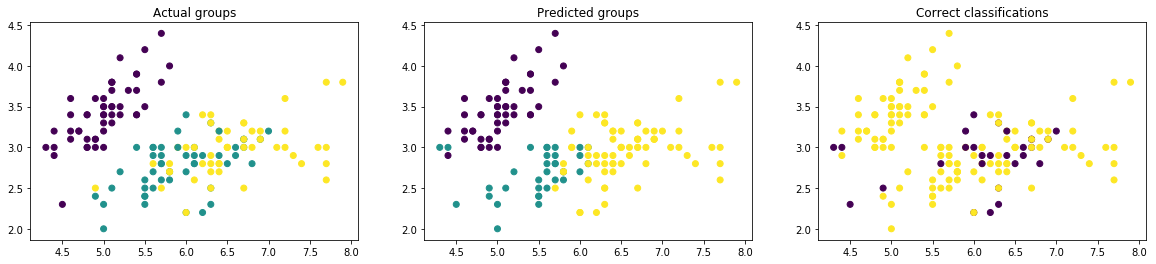

In [277]:
# now let's run the whole thing with all bells and whistles

#pre-allocate arrays
overallpred=np.full([len(Y),len(set(Y))],np.nan)
aucs_partial=np.full([nfolds,len(set(Y))],np.nan)
f1s_partial=np.full([nfolds,len(set(Y))],np.nan)

fold=-1
for train_index, test_index in kf.split(X):
    fold+=1
    #print('fold '+ str(fold))
    x2use=X[train_index,:]
    y2use=Y[train_index]
    nboot=10
    # make prediction model based on training set
    betas=bag_log(x2use,y2use,nboot) 
    # predict test set groups
    x2use=X[test_index,:]
    y2use=Y[test_index]
    u=set(y2use)
    for n in u:
        a=len(np.where(y2use==n)[0])
        b=len(np.where(y2use!=n)[0])
        #print(str(a) + ' from group ' + str(n) + ' in test set, n=' + str(len(y2use)))
        n_y2use=np.zeros(shape=[len(y2use)])
        n_y2use[np.where(y2use==n)[0]]=1
        [aucs_partial[fold,n],f1s_partial[fold,n], newpred]=getmetrics(x2use, n_y2use,betas[:,n])
        #print('    AUC: '+ str(aucs_partial[fold,n]) + ', F1 score: '+ str(f1s_partial[fold,n]))
        overallpred[test_index,n]=newpred

#pre-allocate arrays
aucs=np.zeros(shape=[nfolds,nclus])
betas2use=np.zeros(shape=[nfolds,nclus,X.shape[1]])
f1s=np.zeros(shape=[nfolds,nclus])
# considering only the test sets constituting the whole sample, get model fit metrics
for n in range(len(set(Y))):
    truth=np.zeros(shape=[len(Y)])
    truth[np.where(Y==n)[0]]=1
    aucs=roc_auc_score(truth,overallpred[:,n])
    f1s=f1_score(truth,overallpred[:,n])
    print('group '+ str(n) + ': AUC='+ str(aucs) + ', F1 score='+ str(f1s))
        
groupclass=np.zeros(shape=[X.shape[0]])
for n in range(len(set(Y))):
    groupclass[np.where(np.max(overallpred-np.expand_dims(overallpred[:,n],axis=1),axis=1)==0)]=n
# plot overall prediction
correctclass=np.zeros(shape=[X.shape[0]])
correctclass[np.where((Y-groupclass)==0)[0]]=1
fig=plt.figure(figsize=[20,4])
fig.add_subplot(1,3,1); plt.scatter(X[:,0],X[:,1],c=Y); plt.title('Actual groups')
fig.add_subplot(1,3,2); plt.scatter(X[:,0],X[:,1],c=groupclass); plt.title('Predicted groups')
fig.add_subplot(1,3,3); plt.scatter(X[:,0],X[:,1],c=correctclass); plt.title('Correct classifications')
plt.show()
